<a href="https://colab.research.google.com/github/AshishGusain17/colab_notebooks/blob/main/keras_model_combine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D, multiply, add
from tensorflow.keras.layers import MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
import tensorflow as tf


from tensorflow import keras
from tensorflow.keras import layers
# from keras.utils import to_categorical
from tensorflow.keras.applications import EfficientNetB5
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array


from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import model_from_json
from tensorflow.keras.models import model_from_yaml


import numpy as np
import os
import cv2
import datetime
import shutil
import argparse
import random
import pickle
import h5py
import cv2
import math
import time
import gc
import matplotlib
matplotlib.use("Agg")

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')



GPU_MEMORY_LIMIT = 120

if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_virtual_device_configuration(gpu,
                                                                    [tf.config.experimental.VirtualDeviceConfiguration(
                                                                        memory_limit=GPU_MEMORY_LIMIT)])
    except RuntimeError as e:
        print(e)


In [ ]:
!nvidia-smi 

Fri May 28 18:39:26 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8    15W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
CONV_KERNEL_INITIALIZER = {
    'class_name': 'VarianceScaling',
    'config': {
        'scale': 2.0,
        'mode': 'fan_out',
        'distribution': 'truncated_normal'
    }
}

filters_se = 128
activation = "swish"

filters = 3072

filters_out = 512

bn_axis = 3

drop_rate = 0.19487179487179487

depth_divisor = 8
width_coefficient = 1.6



# se = layers.Reshape((1, 1, filters), name=name + 'se_reshape')(se)

inp1 = Input(shape = (1, 1, 3072))
inp2 = Input(shape = (None, None, 3072))
inp3 = Input(shape = (None, None, 512))



In [ ]:
def round_filters(filters, divisor=depth_divisor):
    """Round number of filters based on depth multiplier."""
    filters *= width_coefficient
    new_filters = max(divisor, int(filters + divisor / 2) // divisor * divisor)
    # Make sure that round down does not go down by more than 10%.
    if new_filters < 0.9 * filters:
        new_filters += divisor
    return int(new_filters)
    
    
    
def func(m_name, neuron):
    x = Conv2D(
        filters_se,
        1,
        padding='same',
        activation=activation,
        kernel_initializer=CONV_KERNEL_INITIALIZER,
        name = 'block7c_se_reduce' + m_name)(inp1)
    # print(x.get_shape)

    x = Conv2D(
        filters,
        1,
        padding='same',
        activation='sigmoid',
        kernel_initializer=CONV_KERNEL_INITIALIZER,
        name = 'block7c_se_expand' + m_name)(x)

    x = multiply([inp2, x], name = 'block7c_se_excite' + m_name)

    # Output phase
    x = Conv2D(
        filters_out,
        1,
        padding='same',
        use_bias=False,
        kernel_initializer=CONV_KERNEL_INITIALIZER,
        name = 'block7c_project_conv' + m_name)(x)

    x = BatchNormalization(axis=bn_axis, name = 'block7c_project_bn' + m_name)(x)

    x = Dropout(drop_rate, noise_shape=(None, 1, 1, 1), name = 'block7c_drop' + m_name)(x)

    x = add([x, inp3], name = 'block7c_add' + m_name)





    # Build top
    x = Conv2D(
        round_filters(1280),
        1,
        padding='same',
        use_bias=False,
        kernel_initializer=CONV_KERNEL_INITIALIZER,
        name='top_conv' + m_name)(x)

    x = BatchNormalization(axis=bn_axis, name='top_bn' + m_name)(x)

    x = Activation(activation, name='top_activation' + m_name)(x)

    x = GlobalAveragePooling2D()(x)


    outputs = Dense(neuron, activation = 'sigmoid')(x)
    return outputs
        


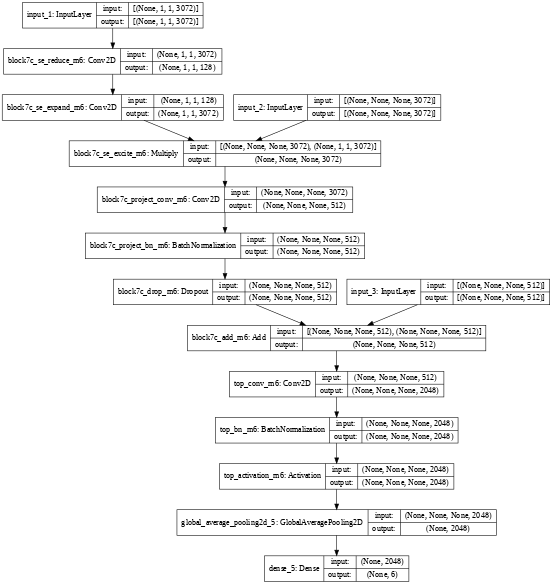

In [ ]:
output1 = func("_m1", 1)
model1 = Model(inputs = [inp1, inp2, inp3], outputs = output1)
plot_model(model1, to_file='model1.png',show_shapes=True, dpi=40)


output2 = func("_m2", 2)
model2 = Model(inputs = [inp1, inp2, inp3], outputs = output2)
plot_model(model2, to_file='model2.png',show_shapes=True, dpi=40)


output3 = func("_m3", 3)
model3 = Model(inputs = [inp1, inp2, inp3], outputs = output3)
plot_model(model3, to_file='model3.png',show_shapes=True, dpi=40)


output4 = func("_m4", 4)
model4 = Model(inputs = [inp1, inp2, inp3], outputs = output4)
plot_model(model4, to_file='model4.png',show_shapes=True, dpi=40)


output5 = func("_m5", 5)
model5 = Model(inputs = [inp1, inp2, inp3], outputs = output5)
plot_model(model5, to_file='model5.png',show_shapes=True, dpi=40)


output6 = func("_m6", 6)
model6 = Model(inputs = [inp1, inp2, inp3], outputs = output6)
plot_model(model6, to_file='model6.png',show_shapes=True, dpi=40)

In [ ]:
!nvidia-smi

Fri May 28 18:39:28 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    27W /  70W |    342MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

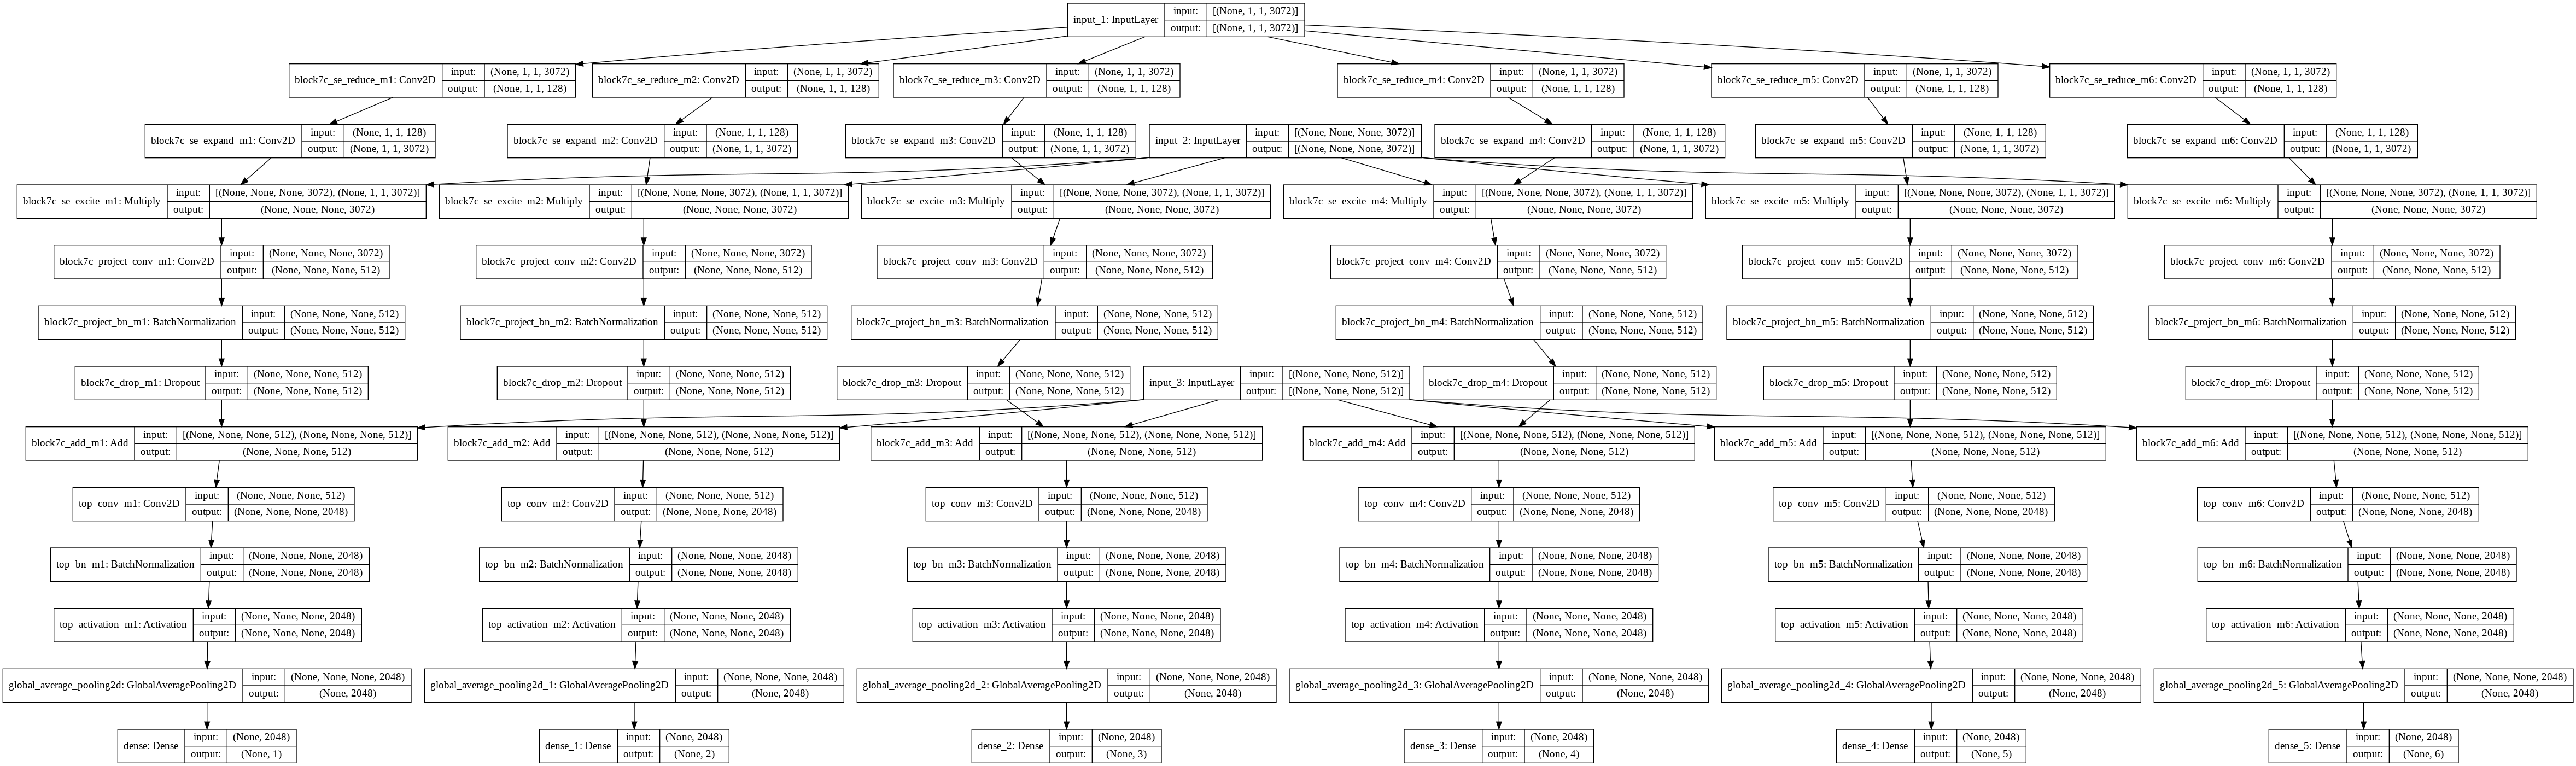

In [ ]:
mm = Model(inputs=[inp1, inp2, inp3], outputs=[output1, output2, output3, output4, output5, output6])
plot_model(mm, to_file='mm.png',show_shapes=True)

In [ ]:
!nvidia-smi

Fri May 28 18:39:28 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    27W /  70W |    342MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
inp1 = Input(shape = (1, 1, 3072))
inp2 = Input(shape = (None, None, 3072))
inp3 = Input(shape = (None, None, 512))


ans = [np.random.rand(1,1, 1, 3072), np.random.rand(1, 14, 14, 3072), np.random.rand(1, 1, 1, 512)]

In [ ]:
for i in range(10):
    st1 = time.time()

    model1.predict(ans)
    st2 = time.time()

    model2.predict(ans)
    st3 = time.time()

    model3.predict(ans)
    st4 = time.time()

    model4.predict(ans)
    st5 = time.time()

    model5.predict(ans)
    st6 = time.time()

    model6.predict(ans)
    st7 = time.time()

    mm.predict(ans)
    st8 = time.time()

    print((st2-st1)*1000, 
          (st3-st2)*1000, 
          (st4-st3)*1000, 
          (st5-st4)*1000,
          (st6-st5)*1000,
          (st7-st6)*1000,
          (st8-st7)*1000)

1962.6398086547852 93.80197525024414 91.65191650390625 89.90740776062012 106.4763069152832 220.83640098571777 382.25507736206055
45.240163803100586 55.51028251647949 37.96267509460449 37.52255439758301 40.49396514892578 38.27023506164551 53.862571716308594
46.69547080993652 38.252830505371094 41.49484634399414 55.27663230895996 42.926788330078125 37.70852088928223 55.1600456237793
45.65906524658203 38.12265396118164 36.94891929626465 37.68801689147949 37.15920448303223 41.304826736450195 53.27033996582031
46.358585357666016 40.65084457397461 37.22095489501953 38.301706314086914 57.27505683898926 42.3738956451416 55.42469024658203
46.6761589050293 38.538455963134766 38.0556583404541 38.78211975097656 41.70584678649902 40.80939292907715 49.929141998291016
46.56219482421875 44.76785659790039 39.56723213195801 57.375192642211914 44.72064971923828 38.18845748901367 54.54874038696289
41.95857048034668 44.142723083496094 37.37497329711914 37.89258003234863 37.685394287109375 41.53656959533691

In [ ]:
!nvidia-smi

Fri May 28 18:39:34 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    37W /  70W |    810MiB / 15109MiB |      9%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------